In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
base = automap_base()
base.prepare(autoload_with=engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station


In [15]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

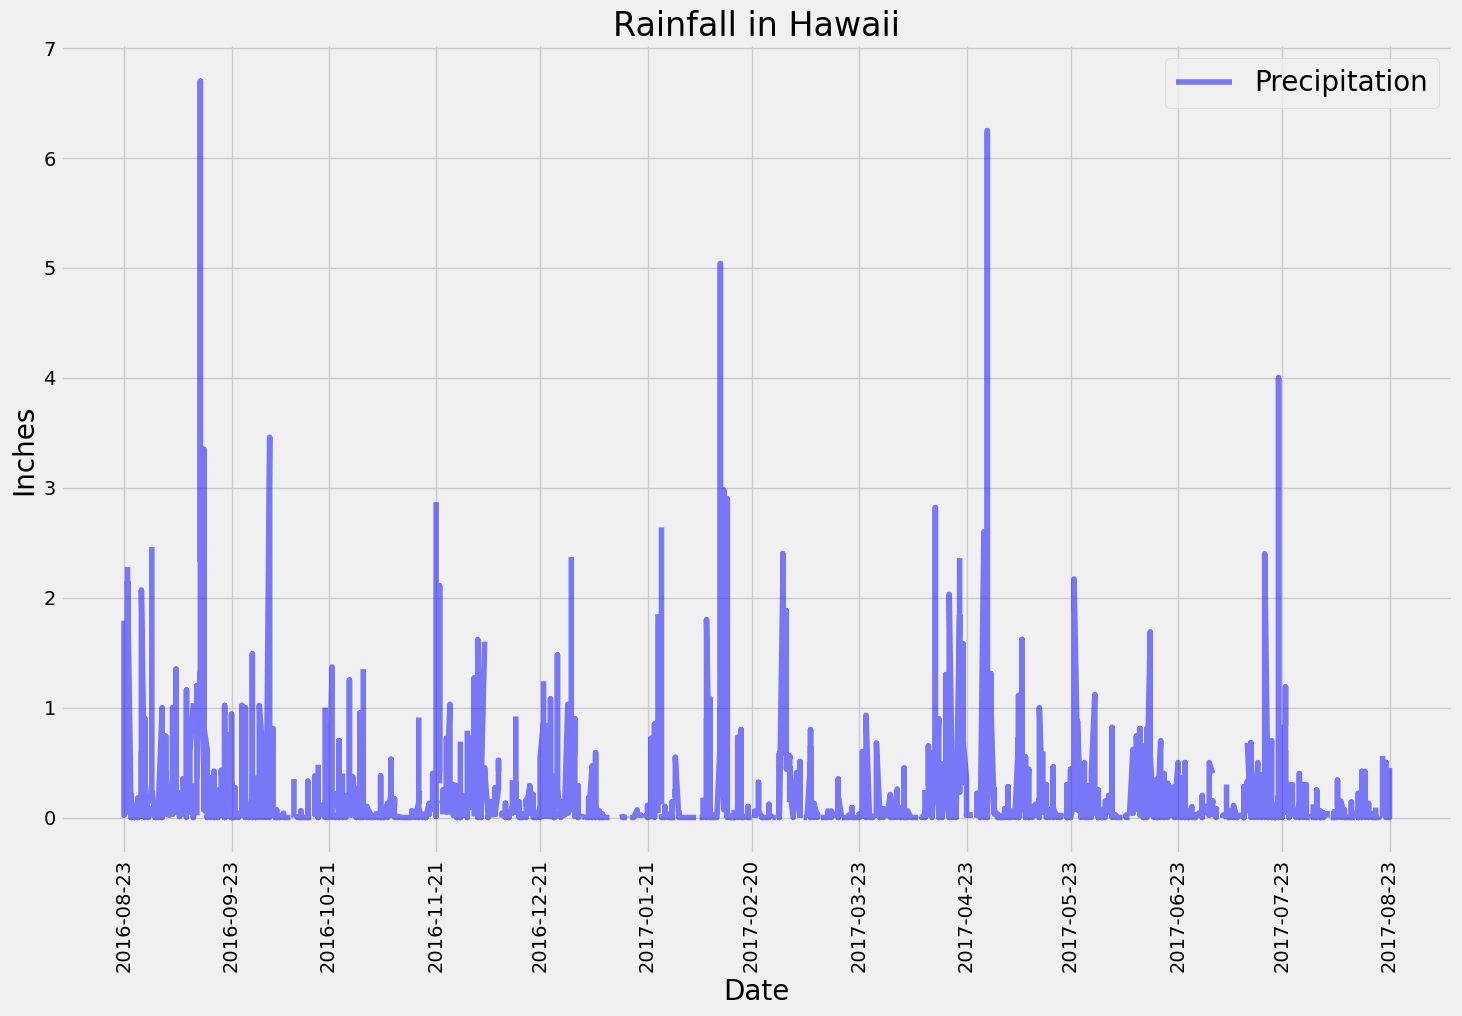

In [17]:
# Starting from the most recent data point in the database. 
most_recent_date = dt.date.fromisoformat(recent_date[0])

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in data set.
first_date = most_recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp)
precip_data = precip_data.filter(measurement.date >= first_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
rain_df.set_index('Date', inplace=True)


# Sort the dataframe by date
rain_df = rain_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(rain_df.index, rain_df['Precipitation'], color='blue', alpha=0.5)
ax.set_title('Rainfall in Hawaii', fontsize=24)
ax.set_xlabel('Date', fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90)
ax.set_ylabel('Inches', fontsize=20)
ax.legend(['Precipitation'], fontsize=20)
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = rain_df.describe()
sum_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(station.station).count()
stations

9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'Lowest Temperature: {temp_stats[0][0]}\nHighest Temperature: {temp_stats[0][1]}\nAverage Temperature: {round(temp_stats[0][2], 2)}')

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


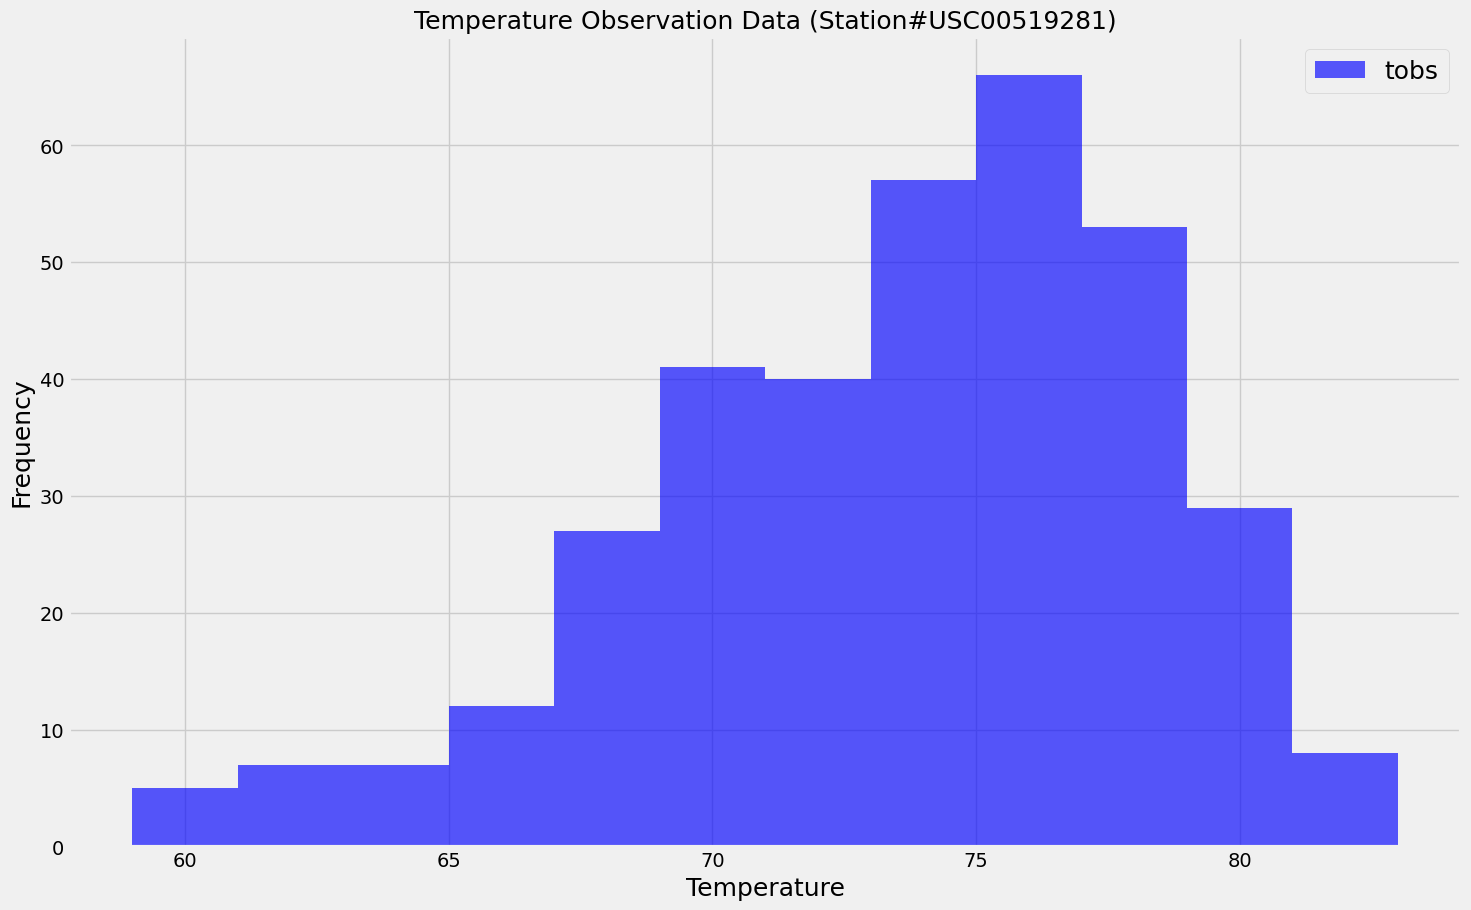

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).all()
year_temp_df = pd.DataFrame(year_temp, columns=['tobs'])

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(10)
ax.hist(year_temp_df['tobs'], bins=12, color='blue', alpha=0.65)
ax.set_title('Temperature Observation Data (Station#USC00519281)', fontsize=18)
ax.set_xlabel('Temperature', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.legend(['tobs'], fontsize=18)
plt.show()

# Close Session

In [23]:
# Close Session
session.close()